# Table of Contents
* [Submitting HITs](#Submitting-HITs)
	* [Building URLs for images on s3](#Building-URLs-for-images-on-s3)
	* [submitting HITs in groups](#submitting-HITs-in-groups)
		* [creates HITs, careful with this one](#creates-HITs,-careful-with-this-one)
* [Reviewing latest HITs](#Reviewing-latest-HITs)
	* [download](#download)
	* [process](#process)
	* [clustering](#clustering)
		* [The two commands above interact with mechanical turk and can take a while](#The-two-commands-above-interact-with-mechanical-turk-and-can-take-a-while)
* [Merging latest round of HITs into combined dataset](#Merging-latest-round-of-HITs-into-combined-dataset)
	* [Load previously pickled results](#Load-previously-pickled-results)
	* [Load prior complete dataset if not in memory](#Load-prior-complete-dataset-if-not-in-memory)
	* [Updating full dataset](#Updating-full-dataset)
	* [Working with full dataset](#Working-with-full-dataset)
		* [worker specific](#worker-specific)
		* [Reviewing full dataset](#Reviewing-full-dataset)
		* [Sanitizing results- questions marked as answers](#Sanitizing-results--questions-marked-as-answers)
* [Worker analysis](#Worker-analysis)
	* [Basic worker stats](#Basic-worker-stats)
		* [HIT duration for pricing](#HIT-duration-for-pricing)
	* [Identifying high and low consensus workers](#Identifying-high-and-low-consensus-workers)
	* [Messaging workers](#Messaging-workers)
* [HIT end-of-life](#HIT-end-of-life)
	* [Pickle latest results](#Pickle-latest-results)
	* [Pickle combined dataset](#Pickle-combined-dataset)
	* [Accepting and deleting HITs... careful with these](#Accepting-and-deleting-HITs...-careful-with-these)
* [End](#End)


In [13]:
%%capture
from __future__ import division
import numpy as np
import pandas as pd
import scipy.stats as st
import itertools
import math
from collections import Counter, defaultdict
%load_ext autoreload
%autoreload 2

import matplotlib as mpl
mpl.use("Agg")
import matplotlib.pylab as plt
#%matplotlib notebook
%matplotlib inline
%load_ext base16_mplrc
%base16_mplrc light default
plt.rcParams['figure.figsize'] = (16.0, 10.0)

import re
from datetime import datetime
import dateutil.parser as dt_parse
import pickle
import boto
import json
import os

from copy import deepcopy
import boto.mturk.connection as tc
import boto.mturk.question as tq
from boto.mturk.qualification import PercentAssignmentsApprovedRequirement, Qualifications, Requirement

from keysTkingdom import mturk_ai2
from keysTkingdom import aws_tokes
from keysTkingdom import mturk_aristo

from amt_utils import process_hits as amt_util

# Submitting HITs

## Building URLs for images on s3

In [163]:
turk_data_flat_dir = '/Users/schwenk/wrk/pqa/ai2-vision-turk-data/pqa-annotation/images'

In [164]:
with open('../sunrgbd/rem_image.pkl', 'r') as f:
    remaining_images = pickle.load(f)

In [166]:
image_names = set(remaining_images).intersection(set(imgn.split('.jpg')[0] for imgn in os.listdir(turk_data_flat_dir)))

In [167]:
s3_base = 'https://s3-us-west-2.amazonaws.com/ai2-vision-turk-data/pqa-annotation/build/'

def make_hit_url(image_name):
    hit_url = s3_base + 'index.html?url={}'.format(image_name + '.jpg')
    return hit_url

In [168]:
hit_urls = [make_hit_url(image_name) for image_name in image_names]

In [169]:
# for  i in np.random.choice(hit_urls, 10):
#     print i

## submitting HITs in groups

In [243]:
## Switch between sandbox and the real world here ##
## DON'T FORGET to change submission POST request in the client ##

sandbox_host = 'mechanicalturk.sandbox.amazonaws.com' 
real_world_host = 'mechanicalturk.amazonaws.com'
mturk = tc.MTurkConnection(
    aws_access_key_id = aws_tokes.access_key,
    aws_secret_access_key = aws_tokes.access_secret_key,
    debug = 1, # debug = 2 prints out all requests.
    host = sandbox_host
)
current_account_balance = mturk.get_account_balance()[0]
print current_account_balance # a reminder of sandbox

$10,000.00


In [230]:
static_params = {
    'title': "Find attached obects in an image",
    'description': "Select objects in a room that are attached to a surface",
    'keywords': ['image', 'object tagging'],
    'frame_height': 800,
    'amount': 0.03,
    'duration': 3600 * 12,
    'lifetime': 3600 * 24 * 3,
    'max_assignments': 3,
    'response_groups': ['HITDetail'],
    'quals': [new_requirement]
}

In [210]:
expected_cost = len(images_to_submit) *  static_params['amount'] * static_params['max_assignments']
print expected_cost

0.9


### creates HITs, careful with this one

In [186]:
images_to_submit = hit_urls[:10]
expected_cost = len(images_to_submit) *  static_params['amount'] * static_params['max_assignments']
if float(current_account_balance.amount) < expected_cost:
    print('WARNING -- account balance is too low -- WARNING')
print('expect this batch of HITs to cost: $' + str(expected_cost))

expect this batch of HITs to cost: $0.9


uncomment cell below only when ready to submit

In [229]:
new_requirement = Requirement(new_qual.QualificationTypeId, 'EqualTo', integer_valufrom boto.mturk.qualification import Requiremente=1)

In [238]:
amt_util.create_single_hit(mturk, images_to_submit[0], static_params)

In [187]:
# amt_util.create_hits_from_pages(mturk, images_to_submit, static_params)

# Reviewing latest HITs

## download

In [244]:
r_hits_current_batch = amt_util.get_completed_hits(mturk)
assignment_results_current_batch = amt_util.get_assignments(mturk, r_hits_current_batch)

In [245]:
len(assignment_results_current_batch)

0

In [6]:
len(assignment_results_current_batch) * 3

1377

In [240]:
test_hit = r_hits_current_batch[0]

In [246]:
len(dir(test_hit))

24

## process

In [14]:
raw_results = amt_util.process_raw_hits(assignment_results_current_batch)

In [16]:
%%time 
raw_res_df = amt_util.make_results_df(raw_results)

CPU times: user 1min 34s, sys: 6.28 s, total: 1min 40s
Wall time: 1min 41s


In [ ]:
df=DataFrame(np.zeros(0,dtype=[
('ProductID', 'i4'),
('ProductName', 'a50')]))

In [ ]:
df = df.append({'ProductID':1234, 'ProductName':'Widget'})

In [23]:
raw_res_df.head(1)

,page,category,hit_id,assignment_id,box_id,worker_id
0,img_0569.jpg,unlabeled,3L1EFR8WWT6FZILZ75LDN1C4Z2L9FI,3U4J9857OECOV2JKD86YEZPX2SL7BE,T0,A2LHZ0LT9BOG0U


In [190]:
all_hits = list(mturk.get_all_hits())

In [192]:
th1 = all_hits[0]

In [196]:
th1.Keywords

u'image, object tagging'

In [40]:
%%time 
raw_res_df = amt_util.make_results_df(raw_results)

CPU times: user 67.1 ms, sys: 17.5 ms, total: 84.6 ms
Wall time: 78.5 ms


In [42]:
%%time
consensus_res_df = amt_util.make_consensus_df(raw_res_df, 'NO CONSENSUS')

CPU times: user 26.6 s, sys: 194 ms, total: 26.8 s
Wall time: 26.8 s


In [333]:
consensus_res_df.to_pickle('second_round_results.pkl')

In [275]:
pd.unique(consensus_res_df['page']).shape

(2338,)

In [326]:
grouped_by_page = raw_res_df.groupby(['page', 'box_id'])
aggregated_df = grouped_by_page.agg(lambda x:len(set(x)) == 1)
aggregated_df.drop(['assignment_id', 'worker_id'], axis=1, inplace=True)
aggregated_df = aggregated_df.reset_index()

In [328]:
all_match = aggregated_df[['category']].copy()

In [329]:
consensus_res_df['all_con'] = all_match

In [330]:
consensus_res_df['stringent_category'] = consensus_res_df['category'] * consensus_res_df['all_con']
consensus_res_df['stringent_category'] = consensus_res_df['stringent_category'].replace(r'', 'unlabeled', regex=True)

In [327]:
consensus_res_df = make_consensus_df(raw_res_df, 'NO CONSENSUS')

In [200]:
attached_qual = mturk.create_qualification_type('attached objects finding' , 'This is a qualification for finding attached objects in a scene.', status='Active')
new_qual = attached_qual[0]
new_qual.QualificationTypeId

In [202]:
my_id = 'ATRVCA186WV1B'

In [239]:
# mturk.assign_qualification(new_qual.QualificationTypeId, my_id)

In [332]:
consensus_res_df

,page,box_id,category,hit_id,all_con,stringent_category
0,000002_2014-05-26_14-23-37_260595134347_rgbf00...,T0,Attached,3K2CEDRACBXXCGVB23PV70R2346TM1,False,unlabeled
1,000002_2014-05-26_14-23-37_260595134347_rgbf00...,T1,unlabeled,3K2CEDRACBXXCGVB23PV70R2346TM1,False,unlabeled
2,000002_2014-05-26_14-23-37_260595134347_rgbf00...,T10,unlabeled,3K2CEDRACBXXCGVB23PV70R2346TM1,True,unlabeled
3,000002_2014-05-26_14-23-37_260595134347_rgbf00...,T2,unlabeled,3K2CEDRACBXXCGVB23PV70R2346TM1,False,unlabeled
4,000002_2014-05-26_14-23-37_260595134347_rgbf00...,T3,Attached,3K2CEDRACBXXCGVB23PV70R2346TM1,False,unlabeled
5,000002_2014-05-26_14-23-37_260595134347_rgbf00...,T4,unlabeled,3K2CEDRACBXXCGVB23PV70R2346TM1,True,unlabeled
6,000002_2014-05-26_14-23-37_260595134347_rgbf00...,T5,unlabeled,3K2CEDRACBXXCGVB23PV70R2346TM1,True,unlabeled
7,000002_2014-05-26_14-23-37_260595134347_rgbf00...,T6,Attached,3K2CEDRACBXXCGVB23PV70R2346TM1,False,unlabeled
8,000002_2014-05-26_14-23-37_260595134347_rgbf00...,T7,unlabeled,3K2CEDRACBXXCGVB23PV70R2346TM1,True,unlabeled
9,000002_2014-05-26_14-23-37_260595134347_rgbf00...,T8,unlabeled,3K2CEDRACBXXCGVB23PV70R2346TM1,True,unlabeled


In [276]:
consensus_res_df['category'].value_counts()

unlabeled    32752
Attached     17169
Name: category, dtype: int64

In [28]:
results_df.shape

(71637, 4)

In [1106]:
def get_boxes_by_user(results_df, current_page):
    diagram_df = results_df[results_df['diagram'] == current_page]
    grouped_by_user = diagram_df.groupby('assignment_id')
    return {k:v['rectangle'].values for k,v in grouped_by_user}

## reading consensus choices

# Merging latest round of HITs into combined dataset 

## Load previously pickled results

In [383]:
batch_number = 7

with open('./store_hit_results_metadata/group_' + str(batch_number) + '/hit_info.pkl') as f:
    r_hits_previous_batch = pickle.load(f)
    
with open('./store_hit_results_metadata/group_' + str(batch_number) + '/assignment_info.pkl') as f:
    assignment_results_previous_batch = pickle.load(f)
    
# with open('./store_hit_results_metadata/group_' + str(batch_number) + '/raw_res.pkl') as f:
#     raw_hit_results_previous_batch = pickle.load(f)

In [397]:
# combined_results_batch = pd.read_pickle(data_pickled_dir + 'complete_df.pkl')
# combined_consensus_batch = pd.read_pickle(data_pickled_dir + 'consensus_df.pkl')

In [405]:
missing_hits = set(assignment_results_previous_batch.keys()).difference(assignment_results_current_batch.keys())
missing_hits_assignments = {k: v for k, v in assignment_results_previous_batch.items() if k in missing_hits}

## Load prior complete dataset if not in memory

In [2]:
data_pickled_dir = './store_hit_results_metadata/group_latest_combined/' 

In [3]:
combined_results_df = pd.read_pickle(data_pickled_dir + 'complete_df.pkl')
combined_consensus_df = pd.read_pickle(data_pickled_dir + 'consensus_df.pkl')
combined_consensus_with_workerid_df = pd.read_pickle(data_pickled_dir + 'consensus_df_w_workers.pkl') 

## Updating full dataset

In [426]:
combined_results_df = combined_results_df.append(results_df_previous_batch)
combined_consensus_df = combined_consensus_df.append(consensus_prev)
combined_consensus_with_workerid_df = combined_consensus_with_workerid_df.append(consensus_prevww)

In [4]:
%%capture
no_consensus_hits = combined_consensus_df[combined_consensus_df['category'] == 'No Consensus']

## Working with full dataset

### worker specific

In [961]:
flaw_rate = len(no_consensus_hits) / len(combined_consensus_df)
print 'text boxes without consensus are ' + '{0:0.2f}% '.format(flaw_rate * 100) + 'of the total'  

In [255]:
workers_to_qualify = worker_quality_df[worker_quality_df['submitted'] > 100].sort_values('flaw_ratio', ascending= True).head(25).index.tolist()

In [ ]:
workers_to_qualify

In [242]:
bad_and_prolific_workers[:15]

,submitted,incorrect,flaw_ratio
A2KM2RWXQV47CV,2900.0,2093.0,0.721724
A16EEWCUQK9LM2,1069.0,446.0,0.417212
A1QZHZZMO2TE51,582.0,215.0,0.369416
A2XJH3WC02RMXQ,134.0,87.0,0.649254
AQE7EQDM98KB7,154.0,47.0,0.305195
A18DRAESIN3E94,112.0,43.0,0.383929
A8TDOYC7FWWKR,67.0,36.0,0.537313
A9Y1HKUEOOEPM,49.0,35.0,0.714286
A1EGJ4WHHIU61V,45.0,24.0,0.533333
A1ESKJFDQUMBL4,68.0,23.0,0.338235


workers who contacted me

In [256]:
wrote_me = ['A3T8FDBJQV81FN',
'A3UUH3632AI3ZX',
'A2QVMCGDLTWV9',
'A356GXVAYWN0DV',
'A2V4PRG5UBNIX0',
'A333VJ2K6O6R79']

In [258]:
workers_to_ban = bad_and_prolific_workers[:5].index.tolist()
set(bad_and_prolific_workers.index).intersection(set(wrote_me))

{'A2V4PRG5UBNIX0'}

In [275]:
workers_to_ban

[u'A2KM2RWXQV47CV',
 u'A16EEWCUQK9LM2',
 u'A1QZHZZMO2TE51',
 u'A2XJH3WC02RMXQ',
 u'AQE7EQDM98KB7']

In [260]:
combined_consensus_with_workerid_df.head()

,assignment_id,box_id,category,consensus_category,hit_id,page,worker_id
8126,32AT8R96GLAPAZCI12L4EGDHN25US0,T1,unlabeled,unlabeled,302OLP89DZ8M1PBU899CBQ2L0VSAC8,Daily_Science_Grade_4_Evan_Moor_55.jpeg,A333VJ2K6O6R79
8144,3WJ1OXY92AHNC6JBHZY8XO1M45D8A9,T1,unlabeled,unlabeled,302OLP89DZ8M1PBU899CBQ2L0VSAC8,Daily_Science_Grade_4_Evan_Moor_55.jpeg,A36PFUM96J0ES6
8162,3N2BF7Y2VQVH7ITTH6IJJSPL15VMHP,T1,unlabeled,unlabeled,302OLP89DZ8M1PBU899CBQ2L0VSAC8,Daily_Science_Grade_4_Evan_Moor_55.jpeg,A2RSOGTSR83XKO
8131,32AT8R96GLAPAZCI12L4EGDHN25US0,T10,Discussion,Discussion,302OLP89DZ8M1PBU899CBQ2L0VSAC8,Daily_Science_Grade_4_Evan_Moor_55.jpeg,A333VJ2K6O6R79
8149,3WJ1OXY92AHNC6JBHZY8XO1M45D8A9,T10,Discussion,Discussion,302OLP89DZ8M1PBU899CBQ2L0VSAC8,Daily_Science_Grade_4_Evan_Moor_55.jpeg,A36PFUM96J0ES6


After looking through the top few offenders, it's clear that 

1. the very worst intentionally submitted many blank pages

2. the rest didn't read the directions very closely

3. I'm comfortable rejecting the work of those with > 100 submissions

4. I'll ban the worst 15 from future HITs


### Reviewing full dataset

In [94]:
amt_util.write_results_df(combined_consensus_df, local_result_path)

In [4]:
# all pages from the complete
pages_to_review =pd.unique(combined_consensus_df['page'])

In [5]:
combined_consensus_df[combined_consensus_df['category'] == 'Question'].shape

(16986, 4)

In [6]:
pages_to_review =pd.unique(combined_consensus_df[combined_consensus_df['category'] == 'Question']['page'])

In [7]:
# all pages from the complete dataset with a no-consensus box
# pages_to_review =pd.unique(no_consensus_hits['page'])

In [8]:
sampling_rate = 0.30
sample_size = int(len(pages_to_review) * sampling_rate)
sampled_pages_to_review = list(np.random.choice(pages_to_review, size= sample_size, replace=False))
print 'sampling ' + str(sample_size) + ' pages out of ' + str(len(pages_to_review))
to_review = ['start_seq'] + sampled_pages_to_review

sampling 401 pages out of 1337


In [39]:
overmerged_dir = 'labeled-annotations/'
unmerged_dir = 'annotations_ws/'
lessmerged_dir = 'lessmerged-annotations/'
remerged_annotations  = 'test-remerged-annotations/'
anno_dir = lessmerged_dir
amt_util.review_results(to_review, anno_dir)
print 'posting to review tool, navigate to http://localhost:8080/ to see the sampled consensus results'

posting to review tool, navigate to http://localhost:8080/ to see the sampled consensus results


In [ ]:
# %%capture 
# # all pages from the latest batch with a no-consensus box

# # suspect_subset = combined_results_df[combined_results_df['worker_id'].isin(bad_and_prolific_to_review[10:15])]
# suspect_subset = combined_results_df[combined_results_df['worker_id'].isin(['A3VE5OH94HYHET'])]
# amt_util.write_results_df(suspect_subset)
# pages_to_review = pd.unique(suspect_subset['page'])

### Sanitizing results- questions marked as answers

In [67]:
question_only_df = combined_consensus_df[combined_consensus_df['category'] == 'Question']

In [68]:
pages_w_questions = pd.unique(question_only_df['page'])
len(pages_w_questions)

1337

In [69]:
combined_df_question_pages_only = combined_consensus_df[combined_consensus_df['page'].isin(pages_w_questions)]

In [111]:
combined_df_question_pages_only.to_pickle('pages_w_questions.pkl')

In [70]:
question_pages_w_answers = pd.unique(combined_df_question_pages_only[combined_df_question_pages_only['category'] == 'Answer']['page'])

In [71]:
question_pages_w_answers.shape

(49,)

In [72]:
incorrectly_marked_answers_df = combined_consensus_df[combined_consensus_df['page'].isin(question_pages_w_answers)]

In [73]:
pd.unique(incorrectly_marked_answers_df['page']).shape

(49,)

In [83]:
to_correct_aq_df = combined_consensus_df[combined_consensus_df['page'].isin(incorrectly_marked_answers_df['page'])]

In [88]:
corrected_aq_df = to_correct_aq_df.replace('Answer', 'Question')

In [105]:
local_result_path='./ai2-vision-turk-data/textbook-annotation-test/corrected_raw_hit_results/'
# local_result_path='./ai2-vision-turk-data/textbook-annotation-test/corrected_unmerged/'

amt_util.write_results_df(corrected_aq_df, local_result_path)

In [106]:
pages_to_review = pd.unique(corrected_aq_df['page'])
sampling_rate = 1
sample_size = int(len(pages_to_review) * sampling_rate)
sampled_pages_to_review = list(np.random.choice(pages_to_review, size= sample_size, replace=False))
print 'sampling ' + str(sample_size) + ' pages out of ' + str(len(pages_to_review))
to_review = ['start_seq'] + sampled_pages_to_review

sampling 49 pages out of 49


In [109]:
# anno_dir = 'corrected_unmerged/'
anno_dir = 'test-remerged-annotations/'

amt_util.review_results(to_review, anno_dir)
print 'posting to review tool, navigate to http://localhost:8080/ to see the sampled consensus results'

posting to review tool, navigate to http://localhost:8080/ to see the sampled consensus results


# Worker analysis

## Basic worker stats

In [103]:
print 'number of unique workers:'
pd.unique(raw_res_df['worker_id']).shape[0]

number of unique workers:


82

In [109]:
all_worker_counts = raw_res_df['worker_id'].value_counts()

grouped_by_worker = raw_res_df.groupby('worker_id')
worker_attached_counts = pd.DataFrame(grouped_by_worker['category'].agg(lambda x: sum(x == 'Attached') / len(x)))

In [110]:
worker_answers_and_fracts = worker_attached_counts.merge(pd.DataFrame(all_worker_counts), left_index=True, right_index=True)
worker_answers_and_fracts.columns = ['fract_attached', 'submissions']

In [117]:
worker_answers_and_fracts

,fract_attached,submissions
A356GXVAYWN0DV,0.123293,2563
AGWH82NB1FO3B,0.390618,2281
A39ZQZ2T5Z7JSB,0.161972,2272
A1RGDYGB3BXDP1,0.172062,2255
A3D0B5IL447G74,0.145342,1782
A10EDAUGQ2JLIW,0.192122,1447
A3Z1W0ACQDGGC,0.449242,1320
AA524FVH76YFT,0.096266,1205
AHXBZXWIZJSVG,0.142562,968
AC4QQ86BQSCJO,0.285714,840


In [128]:
potentially_good_workers = worker_answers_and_fracts[(worker_answers_and_fracts['fract_attached'] < 0.2) & (worker_answers_and_fracts['fract_attached'] > 0.05 )].index.tolist()

In [129]:
len(potentially_good_workers)

39

In [215]:
# with open('good_workers.txt', 'a') as f:
#     with_nl = map(lambda x: x + '\n', potentially_good_workers)
#     f.writelines(with_nl)

### HIT duration for pricing

In [1718]:
task_duration_seconds = []
for hit_id, assignments in assignment_results_current_batch.items():
    for assignment in assignments:
        hit_duration = dt_parse.parse(assignment.SubmitTime) - dt_parse.parse(assignment.AcceptTime)
        task_duration_seconds.append(hit_duration.seconds)

In [1719]:
task_duration_series = pd.Series(task_duration_seconds)

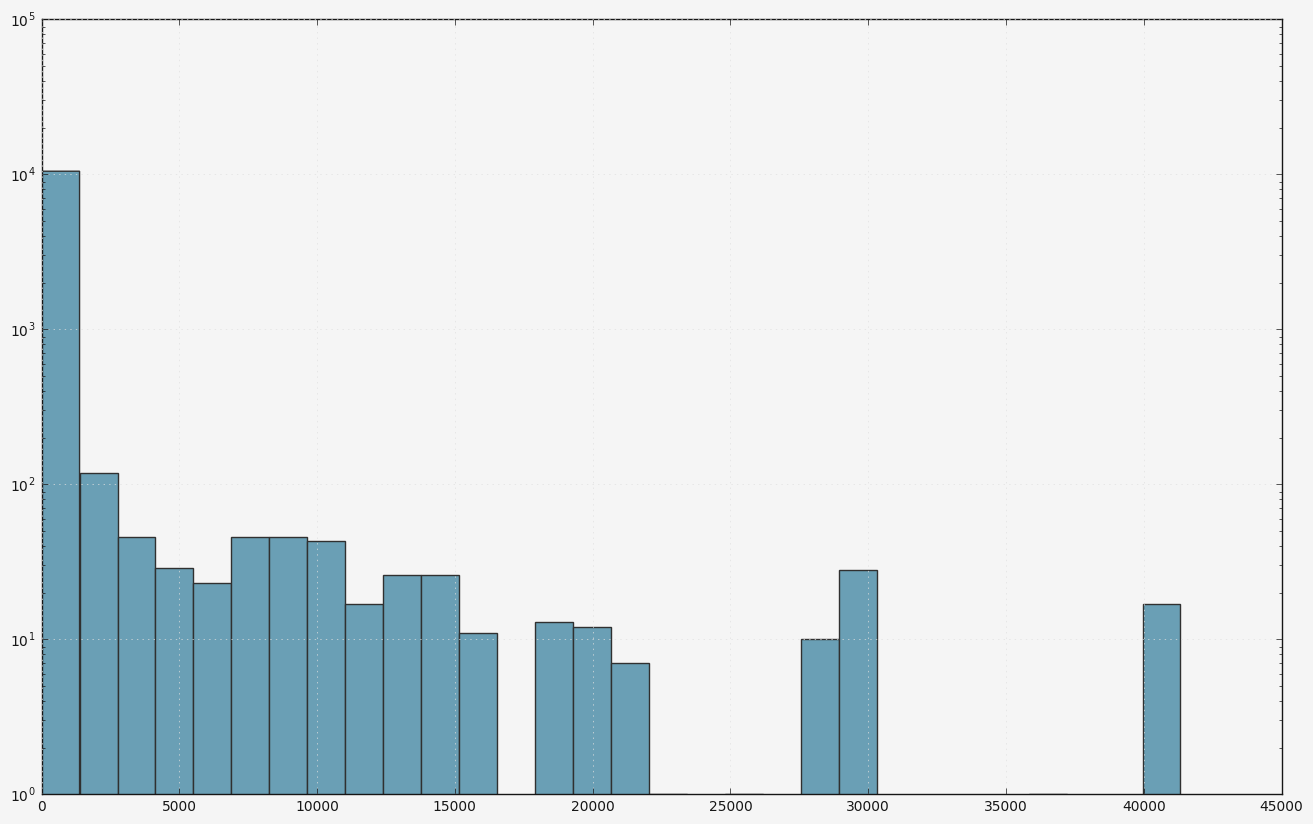

In [1720]:
_ = task_duration_series.hist(bins=30, log=True)

In [1721]:
winsorized_durations = [t for t in task_duration_seconds if t < 300]
w_duration_series = pd.Series(winsorized_durations)

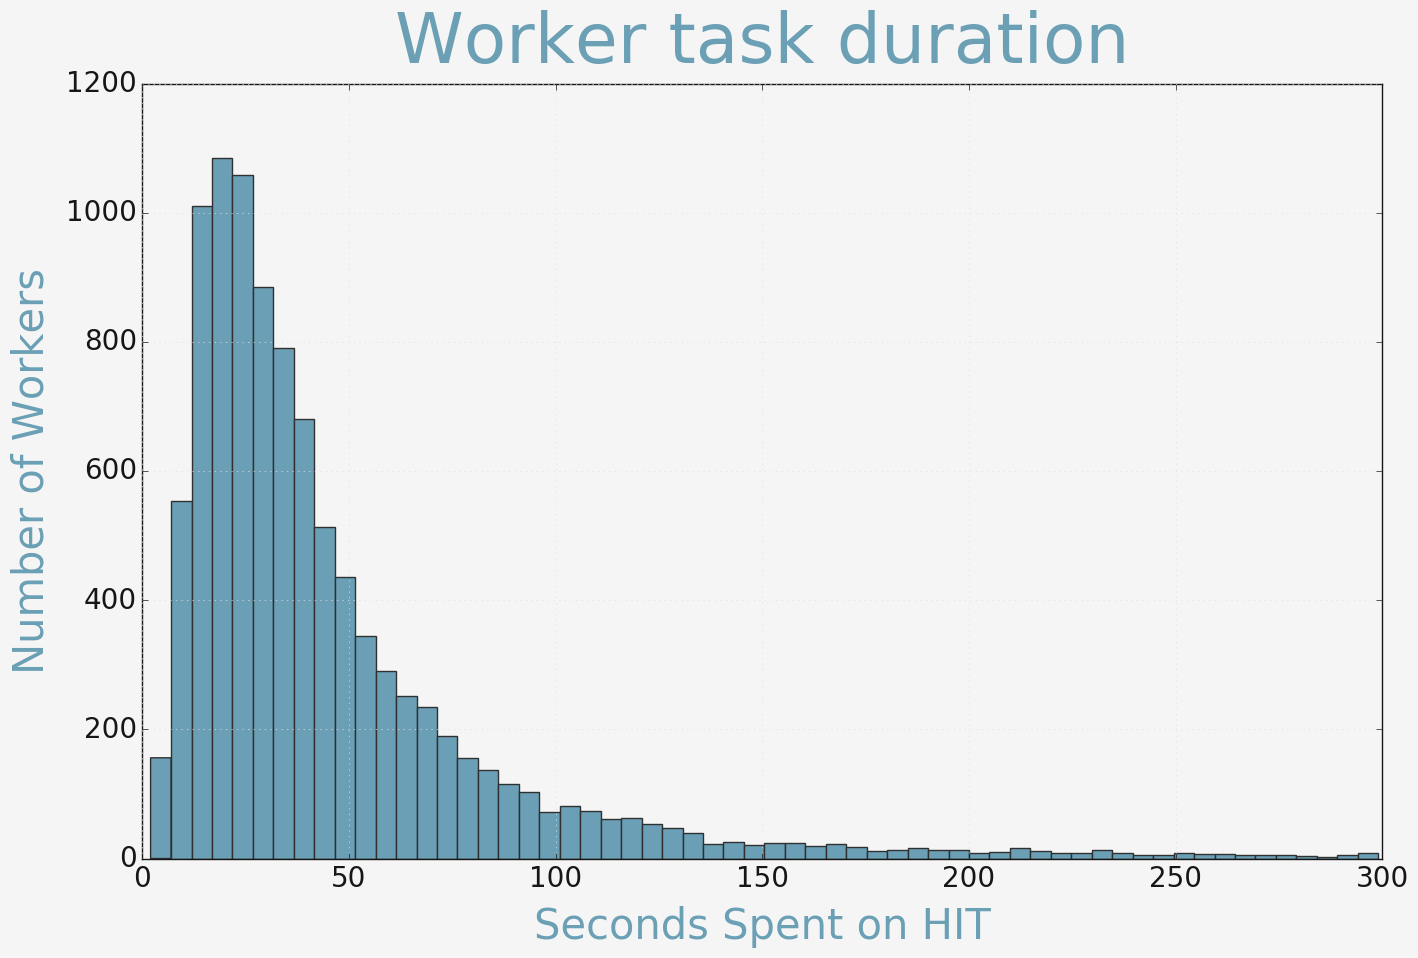

In [1722]:
_ = pd.Series(w_duration_series).hist(bins=60)
plt.title('Worker task duration', fontsize=50, verticalalignment='bottom', color = b16_colors.b)
plt.ylabel("Number of Workers", fontsize=30, labelpad=10, color = b16_colors.b)
plt.xlabel("Seconds Spent on HIT", fontsize=30, labelpad=10, color = b16_colors.b)
plt.tick_params(axis='x', which='major', labelsize=20)
plt.tick_params(axis='y', which='major', labelsize=20)

In [1723]:
print 'duration mode= ' + str(w_duration_series.mode().values[0])
print 'duration median= ' + str(w_duration_series.median())

duration mode= 22
duration median= 33.0


## Identifying high and low consensus workers

In [46]:
%%time
consensus_with_workerid_df_this_batch = amt_util.make_consensus_df_w_worker_id(raw_res_df, consensus_res_df)

CPU times: user 39.3 s, sys: 393 ms, total: 39.7 s
Wall time: 39.8 s


In [58]:
raw_res_df.head(1)

,assignment_id,box_id,category,hit_id,page,worker_id
0,3U4J9857OECOV2JKD86YEZPX2SL7BE,T0,unlabeled,3L1EFR8WWT6FZILZ75LDN1C4Z2L9FI,img_0569.jpg,A2LHZ0LT9BOG0U


In [56]:
consensus_res_df.head(1)

,page,box_id,category,hit_id
0,0000001-000000001587.jpg,T0,unlabeled,3CRWSLD91K5OCFHMVH88FHR2R2IOMH


In [54]:
grouped_by_con = consensus_res_df.groupby(['page', 'box_id'])
grouped_by_raw = raw_res_df.groupby(['page', 'box_id'])

In [88]:
raw_plus_consensus = raw_res_df.merge(consensus_res_df, on=['box_id', 'page'], how='inner')

In [89]:
raw_plus_consensus['matched_consensus'] = raw_plus_consensus['category_x'] == raw_plus_consensus['category_y']

In [101]:
worker_conflicts = raw_plus_consensus[~raw_plus_consensus['matched_consensus']]
worker_conflicts['worker_id'].value_counts()

AGWH82NB1FO3B     560
A3Z1W0ACQDGGC     419
A356GXVAYWN0DV    181
A1RGDYGB3BXDP1    178
AC4QQ86BQSCJO     167
A39ZQZ2T5Z7JSB    122
A3D0B5IL447G74    119
A10EDAUGQ2JLIW    116
A2U8PL0H9LR2BP    107
A1DCW0CE2M58P1     94
A1WV72QNKLU22O     89
AA524FVH76YFT      76
AHXBZXWIZJSVG      75
A2BF4L2P8D4Q0U     64
A3B67I3A0YR2D      56
A3PWONT50E3RZ6     53
A1NUPZR3W070MZ     44
A2ATKF0H50QP2Y     42
A1LQRX3EN2W8U0     42
A2LHZ0LT9BOG0U     38
A2NG6PTOC75UNQ     36
A3TMON68ZR4U84     35
A3EQYMOLG133QS     33
AUW6U0UX2VC7Q      32
ACM6A1BHZCODU      29
A3AQBLODLUJ3SP     29
A1HZWAX6XQXIM7     27
A25OQ8GWGF6S1G     22
A2B5IFTQW98VNQ     20
AAHY5RYKZHXGZ      20
                 ... 
A2DXIQTO5DJSUH     11
A13SNCB7OU5NXR     11
A2LKL8MNCVTPXD     10
ARTQWWNFA7IOD      10
A1ZHZ77PMRFE5F     10
A3GE7CHWBLELVD      9
A2UMB419R9QW8L      9
A8FM0QHYM3R69       8
A3O5R61IF9YJNF      8
ABIYQGG476IUC       8
A3BP890CXV4UMN      7
A171P6LH5DSTD       7
A30YUELTPFSF0T      7
A209L4O92G1VQ5      6
AT5ZOFJP35

In [113]:
worker_conflicts = combined_consensus_with_workerid_df[combined_consensus_with_workerid_df['category'] != combined_consensus_with_workerid_df['consensus_category']]
all_worker_counts = combined_results_df['worker_id'].value_counts()
bad_worker_counts = worker_conflicts['worker_id'].value_counts()
worker_quality_df = pd.DataFrame([all_worker_counts, bad_worker_counts]).T
worker_quality_df.columns=['submitted', 'incorrect']
worker_quality_df['flaw_ratio'] = worker_quality_df['incorrect']/worker_quality_df['submitted']

good_workers = worker_quality_df.sort_values('flaw_ratio', ascending= True).index.tolist()

suspect_workers = worker_quality_df.sort_values('flaw_ratio', ascending= False).index.tolist()

worker_quality_df.sort_values('flaw_ratio', ascending= True).head(10)

,submitted,incorrect,flaw_ratio
A3JOFB6Z65I37Q,124.0,2.0,0.016129
A2HTN7HCNBQ8V4,157.0,3.0,0.019108
A22FK64IWET30E,45.0,1.0,0.022222
AEWGY34WUIA32,1538.0,40.0,0.026008
ASB8T0H7L99RF,507.0,14.0,0.027613
AMA18W8F60Y2J,100.0,3.0,0.030000
A2YY1ZR7Z4VT4M,1517.0,54.0,0.035597
AJFVK3O1D7SPE,1141.0,42.0,0.036810
A10M8ULK8QMRU6,27.0,1.0,0.037037
A2HM35CWB7IIFM,26.0,1.0,0.038462


I became concerned that I missed the perfect performers, but as I suspected perfect workers only did 1-2 HITs at most

In [147]:
aw_set = set(all_worker_counts.index)
bw_set = set(bad_worker_counts.index)
flawless_workers = list(aw_set.difference(bw_set))
all_worker_counts[all_worker_counts.index.isin(best_workers)]

A1N8SWL57W43PV    42
A161I6SGXNY96M    31
A1VL844FUMGC8W    24
A18U9WMYFYJPR6    24
A2U0QL8K0NTGS5    23
A1P47Q6LZPLQ6P    22
A2VL602367WQQW    20
A4UVNGSXE2ANA     20
AFE8IXO7K303F     19
A1HRHFU7KTS0KW    16
Name: worker_id, dtype: int64

In [156]:
bad_and_prolific_workers = worker_quality_df.sort_values('flaw_ratio', ascending= False).head(25).sort_values('incorrect', ascending= False)

In [176]:
bad_and_prolific_to_review = list(bad_and_prolific_workers[:15].index)

## Messaging workers

In [131]:
subject = "more Attached object HITs"
message = """
Hello, 

If you're receiving this message you were among the top performers on the first group HITs I submitted.
I've submitted another group of HITs, with more to follow in the next few days. 
I revised the instructions a little. Just to reiterate, heavy objects like chairs, tables, and couches should not be marked as attached unless they are bolted down or fixed in some other way.

They are under a new account name, but the title and tags are the same.
Happy to get any feedback you might have.
"""

In [132]:
_ = mturk.notify_workers(potentially_good_workers, subject, message)

# HIT end-of-life

## Pickle latest results

In [212]:
#reset as needed
gn = 1

In [213]:
gn

1

In [221]:
next_group = gn + 1
group_n = '_' + str(gn) + '/'

temp_store_dir = './store_hit_results_metadata/group'
try:
    os.mkdir(temp_store_dir + group_n)
except:
    OSError
    
result_file_name = 'hit_info.pkl'
assignment_file_name = 'assignment_info.pkl'
raw_results_file_name = 'raw_res.pkl'
complete_results_file = 'complete_df.pkl'
consensus_results_file = 'consensus_df.pkl'

amt_util.pickle_this(r_hits_current_batch, temp_store_dir + group_n + result_file_name)
amt_util.pickle_this(assignment_results_current_batch, temp_store_dir + group_n + assignment_file_name)
amt_util.pickle_this(raw_hit_results_current_batch, temp_store_dir + group_n + raw_results_file_name)
raw_res_df.to_pickle(temp_store_dir + group_n + complete_results_file)
print 'saved HIT batch number ' + str(gn)
print 'now onto batch ' +str(next_group) 
gn = next_group

saved HIT batch number 1
now onto batch 2


## Pickle combined dataset

In [210]:
temp_store_dir = './store_hit_results_metadata/group'
group_n = '_latest_combined/'
try:
    os.mkdir(temp_store_dir + group_n)
except:
    OSError
    
complete_results_file = 'complete_df.pkl'
consensus_results_file = 'consensus_df.pkl'
consensus_results_file_w_workers = 'consensus_df_w_workers.pkl'

combined_results_df.to_pickle(temp_store_dir + group_n + complete_results_file)
combined_consensus_df.to_pickle(temp_store_dir + group_n + consensus_results_file)
combined_consensus_with_workerid_df.to_pickle(temp_store_dir + group_n + consensus_results_file_w_workers)

NameError: name 'combined_results_df' is not defined

## Accepting and deleting HITs... careful with these

Uncomment only when ready to accept or delete hits

reject assignments carefully

In [236]:
all_hits = list(mturk.get_all_hits())

In [237]:
len(all_hits)

0

In [120]:
test_hit = all_hits[0]

In [342]:
test_hit.HITId

u'3RQVKZ7ZRKFK7EUBFI3ANVLM82X72B'

In [345]:
for a_hit in all_hits:
    mturk.expire_hit(a_hit.HITId)

In [130]:
flattened_assignments = [item for sublist in assignment_results_current_batch.values() for item in sublist]

# len(flattened_assignments)

# # amt_util.get_assignment_statuses(assignment_results_current_batch)

# amt_util.get_assignment_statuses(assignment_results_current_batch)

amt_util.accept_hits(mturk, assignment_results_current_batch)

MTurkRequestError: MTurkRequestError: 200 OK
<?xml version="1.0"?>
<ApproveAssignmentResponse><OperationRequest><RequestId>c5d1d86f-b43d-4990-9f66-2884883f1b16</RequestId></OperationRequest><ApproveAssignmentResult><Request><IsValid>False</IsValid><Errors><Error><Code>AWS.MechanicalTurk.InvalidAssignmentState</Code><Message>This operation can be called with a status of: Submitted (1487731706617)</Message><Data><Key>ExpectedStates</Key><Value>Submitted</Value></Data><Data><Key>CurrentState</Key><Value>Approved</Value></Data><Data><Key>ExpectedStates</Key><Value>Submitted</Value></Data></Error></Errors></Request></ApproveAssignmentResult></ApproveAssignmentResponse>

In [124]:
len(flattened_assignments)

1377

In [437]:
# amt_util.delete_some_hits(mturk, assignment_results_current_batch_post_)

In [235]:
# amt_util.delete_all_hits(mturk)

# End

In [ ]:
def area_intersect_over_union(segmentImage1, segmentImage2, segmentArea1 = 0, segmentArea2 = 0):
    areaIntersection = np.sum(segmentImage1 & segmentImage2)
    if areaIntersection == 0:
        return 0, 0, 0
    if segmentArea1 == 0:
        segmentArea1 = np.sum(segmentImage1)
    if segmentArea2 == 0:
        segmentArea2 = np.sum(segmentImage2)
    areaOverlap = areaIntersection / (segmentArea1 + segmentArea2 - areaIntersection + 0.01)
    areaSelfOverlap1 = areaIntersection / (segmentArea1 + 0.01)
    areaSelfOverlap2 = areaIntersection / (segmentArea2 + 0.01)
    return areaOverlap, areaSelfOverlap1, areaSelfOverlap2


def comp_iou(raw_image, ocr_box, anno_box):

    def update_img(mask, box):
        # box
        # some rectangle of the structure [[start_x, start_y], [end_x, end_y]
        start_x, start_y = box[0]
        end_x, end_y = box[1]
        mask[start_y:end_y + 1, start_x:end_x + 1] = True

    mask_a = np.zeros(raw_image.shape[0:2], dtype=np.bool)
    mask_b = np.zeros(raw_image.shape[0:2], dtype=np.bool)
    update_img(mask_a, ocr_box['rectangle'])
    update_img(mask_b, anno_box['rectangle'])

    areaOverlap, areaSelfOverlap1, areaSelfOverlap2 = areaIntersectOverUnion(mask_a, mask_b)

    #iou = (mask == 2).sum() / (mask >= 1).sum()
    return areaOverlap, areaSelfOverlap1, areaSelfOverlap2 

In [ ]:
problem_name = 'continental_drift_9076.png'
problem = diagram_locs[problem_name]


image_path = flattened_topic_dir + problem_name
drawn_image = draw_clusters(image_path, clustered_text_boxes_centers)
Image.fromarray(drawn_image)

[clust for clust in clustered_text_boxes_centers if len(clust) < 3]

len (clustered_text_boxes)

for box in clustered_text_boxes:
    print box
    print

In [ ]:
# def find_overlapping_boxes(user_boxes):
#     for user in range(1, len(user_boxes)):
#         for box1 in user_boxes[0]:
#             for box2 in sorted(user_boxes[user]):
#                 biou = comp_boxes_iou(box1, box2)
#                 if biou > 0.5
#                     print biou
# #         print